# GDELT API CookBook

The **[GDELT](https://www.gdeltproject.org/) (Global Database of Events, Language and Tone)** is the largest, most comprehensive, and highest resolution open database of human society ever created. It **tracks all media publications published worldwide in 65 languages every 15 minutes**.

With this simple code, you can:

*  **`timelinevolraw` mode**: Extract the volume of matched publications.
*  **`timelinetone` mode**: Extract the tone of the matched publications.
*  **`artlist` mode**: See the specific URLs of the matched publications (a max of 25 URLs are displayed). This can be used for validation.

In [1]:
!pip install gdeltdoc
from gdeltdoc import GdeltDoc, Filters

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from time import sleep
import re

In [29]:
print(query_string)

immigration spain theme:(theme:MIGRATION OR theme:IMMIGRATION) sourcecountry:SP&startdatetime=20240101000000&enddatetime=20241231235959&timezoom=yes


GDELT API is called by using a query string that looks like this (e.g.): `immigration spain theme:(theme:MIGRATION OR theme:IMMIGRATION) sourcecountry:SP&startdatetime=20240101000000&enddatetime=20241231235959&timezoom=yes`. As such, the following code will help construct the proper query and use it to extract the volume, tone and sample URLs of the articles that match the specified search.

In [34]:
# Initiate GDELT
gd = GdeltDoc()

# Parameters
START_DATE = "20240101"  #YYYYmmdd format
END_DATE = "20241231"   #YYYYmmdd format
COUNTRY = 'SP'  # Initials of the publications source country
keywords_list = ['immigration', 'spain']
KEYWORDS = ' '.join(keywords_list) # Must follow format: KEYWORD1 KEYWORD2
themes_list = ['MIGRATION', 'IMMIGRATION']  # Check potential themes at http://data.gdeltproject.org/api/v2/guides/LOOKUP-GKGTHEMES.TXT
THEMES = '(' + ' OR '.join(['theme:' + i for i in themes_list]) + ')'  # Must follow format: THEME1 (THEME2 OR THEME3)

urls = [] # For storing the URLs of the first 25 matched

# API Query Construction
query_string = (
    f"{KEYWORDS} theme:{THEMES} sourcecountry:{COUNTRY}"
    f"&startdatetime={START_DATE}000000"
    f"&enddatetime={END_DATE}235959&timezoom=yes"
)

# API Call
try:
  # URL list (for validation)
  articles_data = gd._query("artlist", query_string)
  if articles_data and "articles" in articles_data:
    articles = list(pd.DataFrame(articles_data['articles'])['url'])
    urls.extend(articles)

  # Article Volume & Tone
  volume = gd._query("timelinevolraw", query_string)
  if volume:
    total_volume = sum(entry['value'] for entry in volume['timeline'][0]['data'])
    volumes = volume['timeline'][0]['data']
    volumes = pd.DataFrame(volumes)
    volumes['Date'] = pd.to_datetime(volumes['date'].str[:8], format='%Y%m%d')
    volumes = volumes.groupby('Date')['value'].sum().rename('Volume')

  tone = gd._query("timelinetone", query_string)
  if tone:
    tones = tone['timeline'][0]['data']
    tones = pd.DataFrame(tones)
    tones['Date'] = pd.to_datetime(tones['date'].str[:8], format='%Y%m%d')
    tones = tones.groupby('Date')['value'].sum().rename('Tone')

  aggregated = pd.concat([volumes, tones], axis=1)

except Exception as e:
  print(f"Error querying GDELT: {e}")

print(aggregated)
print(f"Total articles extracted from {START_DATE} to {END_DATE}:" , total_volume)
print('Sample articles extracted below:')
urls

            Volume    Tone
Date                      
2024-01-01       6 -2.0022
2024-01-02       6 -0.5485
2024-01-03       9 -0.5315
2024-01-04      13 -2.2954
2024-01-05       9 -1.0760
...            ...     ...
2024-12-27      48 -2.6962
2024-12-28      32 -0.9565
2024-12-29      11 -0.6199
2024-12-30      69 -1.3936
2024-12-31      75 -1.9693

[366 rows x 2 columns]
Total articles extracted from 20240101 to 20241231: 11222
Sample articles extracted below:


['https://www.eleconomista.es/opinion/noticias/13151403/12/24/la-inmigracion-que-espana-necesita.html',
 'https://www.europapress.es/epsocial/migracion/noticia-robles-dice-vox-ve-inmigracion-amenaza-elemento-agitar-miedo-odio-20241210153359.html',
 'https://www.que.es/2024/11/26/motivoscontratar-abogado-inmigracion-madrid/',
 'https://www.elblogsalmon.com/indicadores-y-estadisticas/necesitas-inmigracion-100-anos-80-poblacion-espana-habra-desaparecido-tasa-fertilidad-actual',
 'https://gaceta.es/espana/vox-suspende-las-negociaciones-presupuestarias-con-el-pp-por-su-acercamiento-al-psoe-en-politica-migratoria-20241204-1303/',
 'https://www.lavanguardia.com/economia/20241213/10196723/catalunya-madrid-pais-vasco.html',
 'https://www.larazon.es/sociedad/marruecos-desmantelado-este-ano-123-redes-inmigracion-ilegal-espana_20241226676d55b44f1fb700019d00bd.html',
 'https://www.europapress.es/nacional/noticia-vox-atribuye-muertes-migrantes-fronteras-abiertas-pide-combatir-inmigracion-ilegal-salv

For better visualization of the results, since the volume is a count and the tone is in a [-5, 5] range approximately, data scaling can be performed.

<Axes: title={'center': 'Volume and Tone Evolution of the Media'}, xlabel='Date', ylabel='Standard Deviations'>

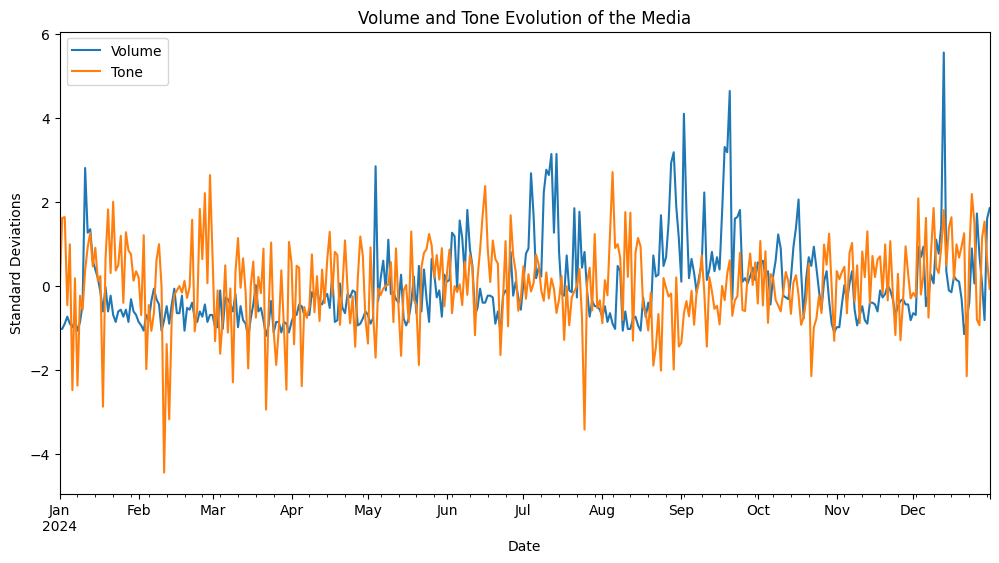

In [36]:
# Plot results: Evolution of publications about immigration in Spain during 2024
for col in aggregated.columns:
  aggregated[col] = (aggregated[col] - aggregated[col].mean()) / aggregated[col].std()

aggregated.plot(figsize=(12, 6), title='Volume and Tone Evolution of the Media', ylabel='Standard Deviations')

A **simple indicator** that incorporates both media volume and tone can be constructed to **better visualize society behavior**.

<Axes: title={'center': 'Society Behavior'}, xlabel='Date', ylabel='Standard Deviations'>

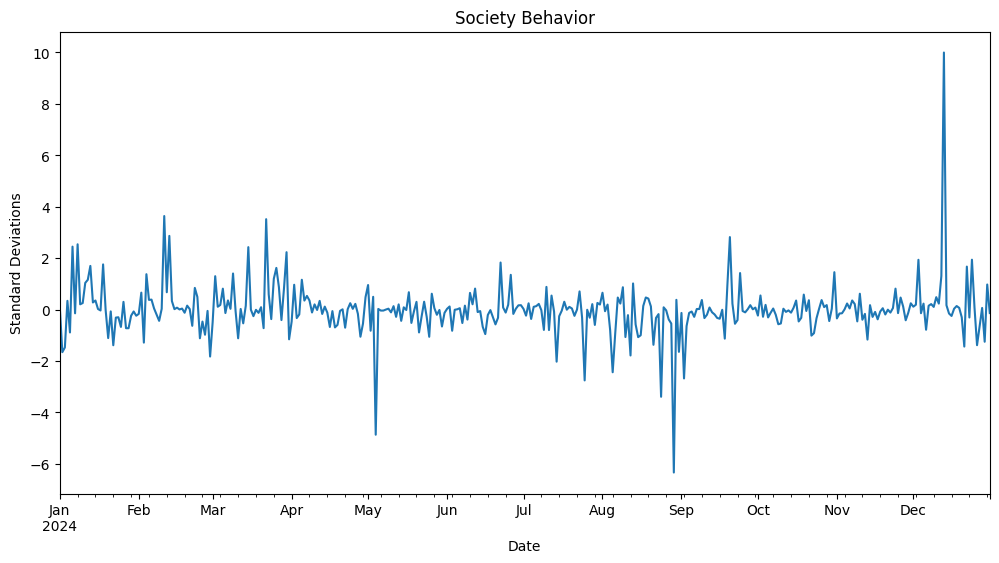

In [37]:
indicator = aggregated['Volume'] * aggregated['Tone']
indicator.plot(figsize=(12, 6), title='Society Behavior', ylabel='Standard Deviations')